In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
random.seed(123)
np.random.seed(123)
tf.set_random_seed(123)

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
n_epochs = 50
batch_size = 50
num_nodes_h1 = 1200
num_nodes_h2 = 1200
learning_rate = 0.001

In [6]:
n_batches = len(mnist.train.images) // batch_size

In [7]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [8]:
def softmax_with_temperature(logits, temp=1.0, axis=1, name=None):
    logits_with_temp = logits / temp
    _softmax = tf.exp(logits_with_temp) / tf.reduce_sum(tf.exp(logits_with_temp), axis=axis, keep_dims=True)
    return _softmax

In [9]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)

W_h1 = weight_variable([784, num_nodes_h1])
b_h1 = bias_variable([num_nodes_h1])
h1 = tf.nn.relu(tf.matmul(x, W_h1) + b_h1)
h1_drop = tf.nn.dropout(h1, keep_prob)

W_h2 = weight_variable([num_nodes_h1, num_nodes_h2])
b_h2 = bias_variable([num_nodes_h2])
h2 = tf.nn.relu(tf.matmul(h1_drop, W_h2) + b_h2)
h2_drop = tf.nn.dropout(h2, keep_prob)

W_output = tf.Variable(tf.zeros([num_nodes_h2, 10]))
b_output = tf.Variable(tf.zeros([10]))
logits = tf.matmul(h2_drop, W_output) + b_output

y = tf.nn.softmax(logits)
y_soft_target = softmax_with_temperature(logits, temp=2.0)
loss = tf.reduce_mean(-tf.reduce_sum(y_*tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
saver = tf.train.Saver()

In [11]:
losses = []
accs = []
test_accs = []

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        x_shuffle, y_shuffle = shuffle(mnist.train.images, mnist.train.labels)
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            batch_x, batch_y = x_shuffle[start:end], y_shuffle[start:end]
            sess.run(train_step, feed_dict={
                                            x: batch_x, y_: batch_y, keep_prob:0.5})
        train_loss = sess.run(loss, feed_dict={x: batch_x, y_: batch_y, keep_prob:0.5})
        train_accuracy = sess.run(accuracy, feed_dict={
                                            x: batch_x, y_: batch_y, keep_prob:1.0})
        test_accuracy = sess.run(accuracy, feed_dict={
                                            x: mnist.test.images, y_: mnist.test.labels, keep_prob:1.0})
        print("Epoch : %i, Loss : %f, Accuracy: %f, Test accuracy: %f" % (
                epoch+1, train_loss, train_accuracy, test_accuracy))
        saver.save(sess, "model_teacher", global_step=epoch+1)
        losses.append(train_loss)
        accs.append(train_accuracy)
        test_accs.append(test_accuracy)
    print("... completed!")

Epoch : 1, Loss : 0.737658, Accuracy: 0.880000, Test accuracy: 0.870400
Epoch : 2, Loss : 0.761210, Accuracy: 0.900000, Test accuracy: 0.877700
Epoch : 3, Loss : 0.589440, Accuracy: 0.920000, Test accuracy: 0.890600
Epoch : 4, Loss : 0.643363, Accuracy: 0.900000, Test accuracy: 0.899800
Epoch : 5, Loss : 0.616030, Accuracy: 0.900000, Test accuracy: 0.900900
Epoch : 6, Loss : 0.611837, Accuracy: 0.860000, Test accuracy: 0.907100
Epoch : 7, Loss : 0.644065, Accuracy: 0.860000, Test accuracy: 0.909300
Epoch : 8, Loss : 0.402908, Accuracy: 0.960000, Test accuracy: 0.911100
Epoch : 9, Loss : 0.572865, Accuracy: 0.960000, Test accuracy: 0.907900
Epoch : 10, Loss : 0.517091, Accuracy: 0.900000, Test accuracy: 0.914700
Epoch : 11, Loss : 0.410243, Accuracy: 0.960000, Test accuracy: 0.914300
Epoch : 12, Loss : 0.945787, Accuracy: 0.800000, Test accuracy: 0.916200
Epoch : 13, Loss : 0.579927, Accuracy: 0.900000, Test accuracy: 0.917000
Epoch : 14, Loss : 0.503721, Accuracy: 0.860000, Test accura

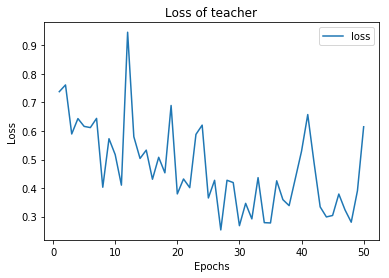

In [13]:
plt.title("Loss of teacher")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.legend()

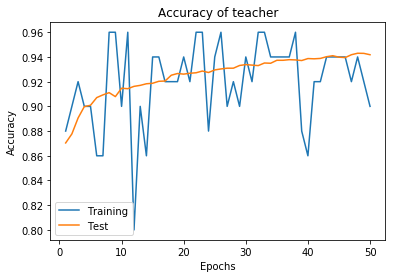

In [14]:
plt.title("Accuracy of teacher")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1, len(accs)+1), accs, label='Training')
plt.plot(range(1, len(test_accs)+1), test_accs, label='Test')
plt.legend()

In [15]:
np.save("loss_teacher.npy", np.array(losses))
np.save("acc_teacher.npy", np.array(accs))
np.save("acc_test_teacher.npy", np.array(test_accs))

In [16]:
! ls model_teacher*

model_teacher-46.data-00000-of-00001  model_teacher-48.meta
model_teacher-46.index		      model_teacher-49.data-00000-of-00001
model_teacher-46.meta		      model_teacher-49.index
model_teacher-47.data-00000-of-00001  model_teacher-49.meta
model_teacher-47.index		      model_teacher-50.data-00000-of-00001
model_teacher-47.meta		      model_teacher-50.index
model_teacher-48.data-00000-of-00001  model_teacher-50.meta
model_teacher-48.index


In [17]:
_soft_targets = []

In [18]:
with tf.Session() as sess:
    saver.restore(sess, "model_teacher-48")
    print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob:1.0}))
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        batch_x = mnist.train.images[start:end]
        soft_target = sess.run(y_soft_target, feed_dict={x: batch_x, keep_prob:1.0})
        _soft_targets.append(soft_target)

INFO:tensorflow:Restoring parameters from model_teacher-48
0.943


In [19]:
soft_targets  = np.c_[_soft_targets].reshape(55000, 10)

In [20]:
soft_targets[:2]

array([[  5.26309339e-03,   6.16717292e-03,   1.52134731e-01,
          6.11851960e-02,   1.48620130e-02,   4.84602200e-03,
          3.68487462e-03,   6.06229186e-01,   2.98353638e-02,
          1.15792304e-01],
       [  2.40928587e-03,   2.67693494e-03,   1.82554703e-02,
          8.58610630e-01,   3.06134025e-04,   1.74290612e-02,
          9.34826749e-05,   3.61788599e-03,   8.34569708e-02,
          1.31440554e-02]], dtype=float32)

In [21]:
mnist.train.labels[:2]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [22]:
np.save('soft-targets.npy', soft_targets)

In [24]:
!ls *.npy

acc_teacher.npy  acc_test_teacher.npy  loss_teacher.npy  soft-targets.npy


In [25]:
np.load(file="soft-targets.npy").shape

(55000, 10)